In [11]:
from transformer import *

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [12]:
# evaluate 
home="/Users/luorunpeng/Downloads/all-e/Research/project-haplotype-phasing/ctgContact-dup"
home2="/Users/luorunpeng/Downloads/all-e/Research/project-haplotype-phasing/run_pt76"
mummer_dir="/Users/luorunpeng/Downloads/all-e/Research/project-haplotype-phasing/benchmark/pt76"
chrom_file=home+"/chrom_id_pt76.lst"

In [13]:
def get_fasta_todict(fasta_file: str):
    res = {}
    with open(fasta_file, "r") as fa_fd:
        sid = ""
        seq = ""
        for line in fa_fd:
            if line.startswith(">"):
                # process previous entry
                if sid != "":
                    res[sid] = seq
                sid = line.strip()[1:].split()[0]
                seq = ""
            else:
                seq += line.strip()
        fa_fd.close()
        if sid != "":
            res[sid] = seq
    return res

In [14]:
# separate the contigs by chromosome names
chr_id2name = {}
name2chr_id = dict()
lefts = []
rights = []
with open(chrom_file, "r") as chrom_fd:
    for line in chrom_fd:
        chrom_id, left, right = line.strip().split("\t")
        chr_id2name[chrom_id] = (left, right)
        name2chr_id[left] = chrom_fd
        name2chr_id[right] = chrom_fd
        lefts.append(left)
        rights.append(right)
    chrom_fd.close()

# parse the Quast csv file
def parse_tsv_file(tsv_file: str):
    chrom_dict = {}
    for name in name2chr_id.keys():
        chrom_dict[name] = []
    with open(tsv_file, "r") as tsv_fd:
        tsv_fd.readline()
        i = 0
        for line in tsv_fd.readlines():
            if i == 0:
                # line 0
                if "unaligned" in line:
                    continue
                splited = line.strip().split()
                s1, e1 = int(splited[0]), int(splited[1])
                rname = str(splited[4])
                cname = str(splited[5])
                mrate = float(splited[6])
                chrom_dict[rname].append((cname, -2, mrate, s1, e1))
            else:
                # line 1
                pass # contig alignment type
            
            i = (i+1) % 2
        tsv_fd.close()
    return chrom_dict

In [15]:
def parse_mfile(mfile: str, k=21):
    """mummer snp detection results - DEBUG only

    Args:
        mfile (str): _description_
    """

    indels = 0
    non_isolated_snp = 0
    higher_snp = 0
    snp = 0

    ignoreN = 0

    A_snps = set()
    B_snps = set()
    snp_index = k//2
    with open(mfile, "r") as fd:
        for line in fd:
            splits = line[:-1].split("\t")
            [sub1, sub2] = splits[1:3]
            [kmer1, kmer2] = splits[8:10]
            if not is_alpha(sub1) or not is_alpha(sub2):
                indels += 1
                continue
            if 'N' in kmer1 or 'N' in kmer2:
                ignoreN += 1
                continue

            A_snps.add(kmer1)
            A_snps.add(reverse_alpha(kmer1))
            B_snps.add(kmer2)
            B_snps.add(reverse_alpha(kmer2))


            if alpha2int(kmer1[:snp_index] + kmer1[snp_index+1:]) != alpha2int(kmer2[:snp_index] + kmer2[snp_index+1:]):
                if hamming_distance(kmer1, kmer2) <= 2:
                    non_isolated_snp += 1
                else:
                    higher_snp += 1
            else:
                snp += 1
    
        fd.close()

    # print("total: ", indels + non_isolated_snp + higher_snp + snp)
    # print("SNP: ", snp)
    # print("non_isolated SNP: ", non_isolated_snp)
    # print("higher order SNP: ", higher_snp)
    # print("indels: ", indels)
    # print("ignore N's kmer: ", ignoreN)

    itsect = A_snps.intersection(B_snps)
    Asnp = A_snps.difference(itsect)
    Bsnp = B_snps.difference(itsect)
    return Asnp, Bsnp

In [16]:
def get_snp_count(hap_file: str, ctg_ids: list, Asnp: set, Bsnp: set):
    k=21
    hapAdict = get_fasta_todict(hap_file)
    hapA_xB = []
    hapA_yA = []
    counter = 0
    ignored=0
    for cid, cseq in hapAdict.items():
        if cid not in ctg_ids: # ignore the contig
            continue
        counter += 1
        yAsnp = 0
        xBsnp = 0
        len_ctg_seq = len(cseq)
        for sub_i in range(len_ctg_seq - k + 1):
            sub = cseq[sub_i : sub_i + k]
            # check global snp 
            if sub in Asnp:
                yAsnp += 1
            elif sub in Bsnp:
                xBsnp += 1
            else:
                pass
        if yAsnp != 0 or xBsnp != 0:
            hapA_xB.append(max(xBsnp//1000, 0))
            hapA_yA.append(max(yAsnp//1000, 0))
        else:
            ignored += 1
    # print(ignored)
    return hapA_xB, hapA_yA

In [17]:
# 1. use tsv and chrom_id to separate the contigs into chromosome bins

def snp_plot(hap_file: str, ctg_ids: list, chr_id: str):
    Asnp, Bsnp = parse_mfile(f"{mummer_dir}/chr{chr_id}.snp")
    return get_snp_count(hap_file, ctg_ids, Asnp, Bsnp)

def sep_contigs_by_chromosome(hap_file: str, tsv_file: str):
    xB = []
    yA = []
    chrom_dict = parse_tsv_file(tsv_file)
    for chr_id, (left, right) in chr_id2name.items():
        ctgs0, ctgs1 = chrom_dict[left], chrom_dict[right]
        ctg_ids0 = [tp[0] for tp in ctgs0]
        ctg_ids1 = [tp[0] for tp in ctgs1]
        # print(len(ctg_ids0), len(ctg_ids1))  
        hapA_xB, hapA_yA = snp_plot(hap_file, ctg_ids0, chr_id)
        hapB_xB, hapB_yA = snp_plot(hap_file, ctg_ids1, chr_id)

        hapA_xB.extend(hapB_xB)
        hapA_yA.extend(hapB_yA)
        xB.extend(hapA_xB)
        yA.extend(hapA_yA)
    
    return xB, yA

        

In [19]:
# fig, axs = plt.subplots(2, 2)
def haplotype_phasing_plot_double(fa1, tsv1, fa2, tsv2, i, j, axes, title):
    hap1_xB, hap1_yA = sep_contigs_by_chromosome(fa1, tsv1)
    hap2_xB, hap2_yA = sep_contigs_by_chromosome(fa2, tsv2)

    ax = axes[i][j]
    ax.scatter(hap1_xB, hap1_yA, label="Haplotype 0",  c="red")
    ax.scatter(hap2_xB, hap2_yA, label="Haplotype 1", c="blue")

    _max1 = max(max(hap1_xB), max(hap1_yA))
    _max2 = max(max(hap2_xB), max(hap2_yA))
    _max = max(_max1, _max2)

    plt.yticks(np.arange(0, _max, 20))
    plt.xticks(np.arange(0, _max, 20))
    ax.set_ylabel("# Haplotype 0 k-mers (10e3)")
    ax.set_xlabel("# Haplotype 1 k-mers (10e3)")
    ax.set_title(title)
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))
    ax.legend()
    print("plot double")
    return

def haplotype_phasing_plot_single(fa1, tsv1, i, j, axes, title):
    hap_xB, hap_yA = sep_contigs_by_chromosome(fa1, tsv1)

    ax = axes[i][j]
    ax.scatter(hap_xB, hap_yA, c="gray")

    _max1 = max(max(hap_xB), max(hap_yA))
    _max = _max1

    plt.yticks(np.arange(0, _max, 20))
    plt.xticks(np.arange(0, _max, 20))
    ax.set_ylabel("# Haplotype 0 k-mers (10e3)")
    ax.set_xlabel("# Haplotype 1 k-mers (10e3)")
    ax.set_title(title)
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))
    print("plot single")
    return

plot single
plot double
plot double
plot double


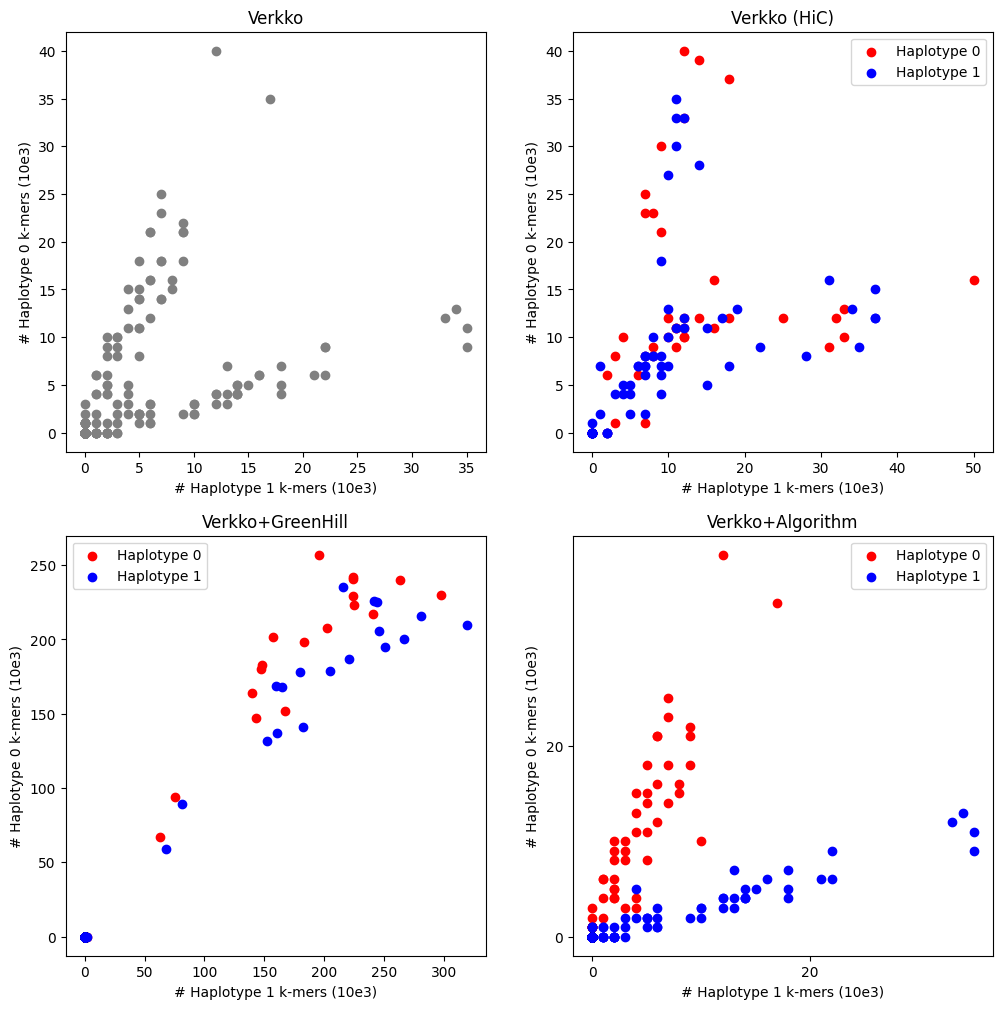

<Figure size 640x480 with 0 Axes>

In [20]:
# verkko
quast_base="/Users/luorunpeng/Downloads/all-e/Research/project-haplotype-phasing/quast_analysis"

quast_dir_pt76=quast_base+"/quast_pt76_all/contigs_reports"
quast_dir_pt76A=quast_base+"/quast_pt76_hapA/contigs_reports"
quast_dir_pt76B=quast_base+"/quast_pt76_hapB/contigs_reports"

# original
all_verkko_tsv=quast_dir_pt76+"/all_alignments_assembly.tsv"
all_verkko_fa=home2+"/run_verkko/verkko/assembly.fasta"

# verkko + HiC
h1_verkko_hic_tsv=quast_dir_pt76A+"/all_alignments_assembly-haplotype1.tsv"
h1_verkko_hic_fa=home2+"/run_verkko/verkko_hic/assembly.haplotype1.fasta"
h2_verkko_hic_tsv=quast_dir_pt76B+"/all_alignments_assembly-haplotype2.tsv"
h2_verkko_hic_fa=home2+"/run_verkko/verkko_hic/assembly.haplotype2.fasta"

# verkko + GreenHill
h1_verkko_greenhill_tsv=quast_dir_pt76A+"/all_alignments_greenhill_verkko_H1.tsv"
h1_verkko_greenhill_fa=home2+"/run_greenhill/coop_verkko/greenhill_verkko_H1.fa"
h2_verkko_greenhill_tsv=quast_dir_pt76B+"/all_alignments_greenhill_verkko_H2.tsv"
h2_verkko_greenhill_fa=home2+"/run_greenhill/coop_verkko/greenhill_verkko_H2.fa"

# verkko + Algorithm
h1_tree_verkko_tsv=quast_dir_pt76A+"/all_alignments_dir_phasing_verkko_pt76_tree_bin0.tsv"
h1_tree_verkko_fa=home+"/dir_phasing_verkko_pt76/tree_bin0.fasta"
h2_tree_verkko_tsv=quast_dir_pt76B+"/all_alignments_dir_phasing_verkko_pt76_tree_bin1.tsv"
h2_tree_verkko_fa=home+"/dir_phasing_verkko_pt76/tree_bin1.fasta"

fig, axes =plt.subplots(2,2)
fig.set_figheight(12)
fig.set_figwidth(12)
haplotype_phasing_plot_single(all_verkko_fa, all_verkko_tsv, 0, 0, axes, "Verkko")

haplotype_phasing_plot_double(h1_verkko_hic_fa, h1_verkko_hic_tsv, h2_verkko_hic_fa, h2_verkko_hic_tsv, 0, 1, axes, "Verkko (HiC)")

haplotype_phasing_plot_double(h1_verkko_greenhill_fa, h1_verkko_greenhill_tsv, h2_verkko_greenhill_fa, h2_verkko_greenhill_tsv, 1, 0, axes, "Verkko+GreenHill")

haplotype_phasing_plot_double(h1_tree_verkko_fa, h1_tree_verkko_tsv, h2_tree_verkko_fa, h2_tree_verkko_tsv, 1, 1, axes, "Verkko+Algorithm")

plt.show()
prefix="pt76_verkko"
plt.savefig(prefix + "_phasing_plot.png")


plot single
plot double
plot double
plot double


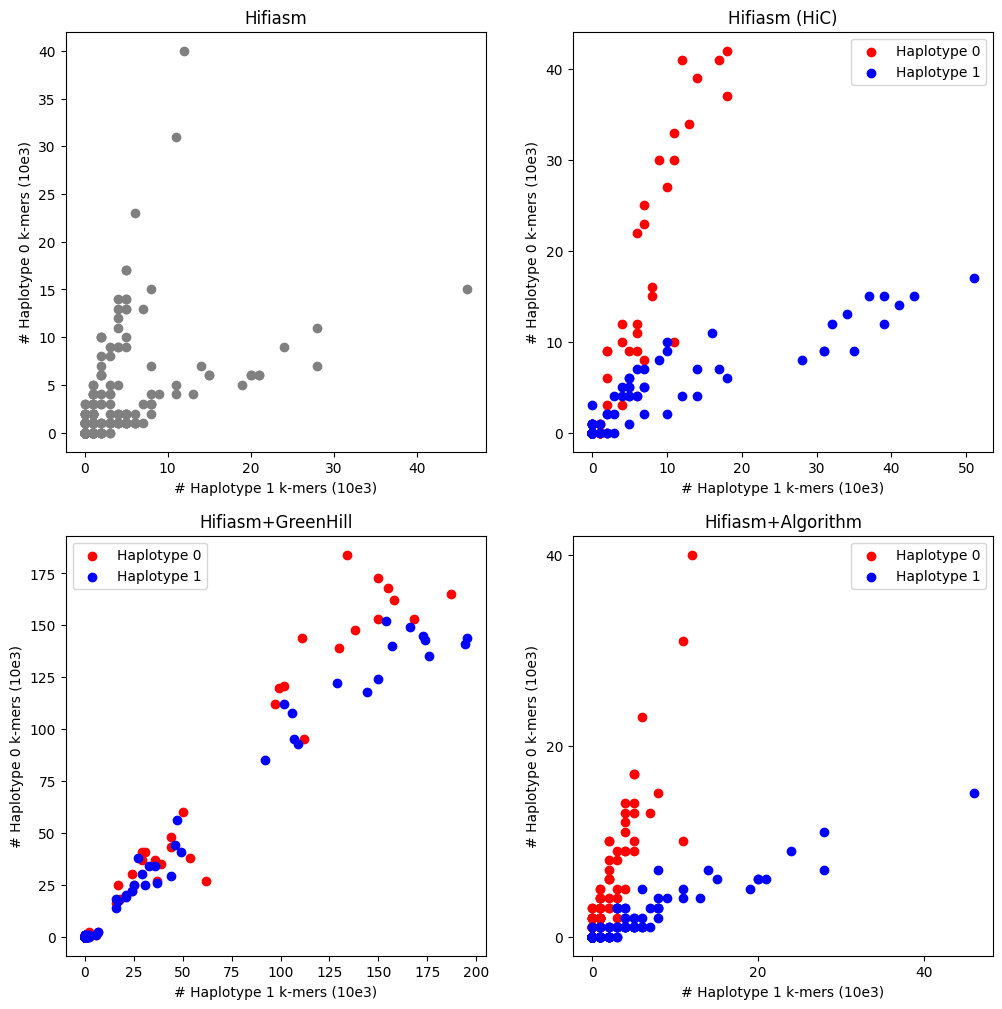

In [22]:
quast_base="/Users/luorunpeng/Downloads/all-e/Research/project-haplotype-phasing/quast_analysis"

quast_dir_pt76=quast_base+"/quast_pt76_all/contigs_reports"
quast_dir_pt76A=quast_base+"/quast_pt76_hapA/contigs_reports"
quast_dir_pt76B=quast_base+"/quast_pt76_hapB/contigs_reports"

# original
all_hifiasm_tsv=quast_dir_pt76+"/all_alignments_pt76_ul-asm-bp-p_utg.tsv"
all_hifiasm_fa=home2+"/run_hifiasm/hifiasm_ul/pt76_ul.asm.bp.p_utg.fasta"

# hifiasm + HiC
h1_hifiasm_hic_tsv=quast_dir_pt76A+"/all_alignments_pt76_ul_hic-asm-hic-hap1-p_ctg.tsv"
h1_hifiasm_hic_fa=home2+"/run_hifiasm/hifiasm_ul_hic/pt76_ul_hic.asm.hic.hap1.p_ctg.fasta"
h2_hifiasm_hic_tsv=quast_dir_pt76B+"/all_alignments_pt76_ul_hic-asm-hic-hap2-p_ctg.tsv"
h2_hifiasm_hic_fa=home2+"/run_hifiasm/hifiasm_ul_hic/pt76_ul_hic.asm.hic.hap2.p_ctg.fasta"

# hifiasm + GreenHill
h1_hifiasm_greenhill_tsv=quast_dir_pt76A+"/all_alignments_greenhill_hifiasm_H2.tsv"
h1_hifiasm_greenhill_fa=home2+"/run_greenhill/coop_hifiasm/greenhill_hifiasm_H2.fa"
h2_hifiasm_greenhill_tsv=quast_dir_pt76B+"/all_alignments_greenhill_hifiasm_H1.tsv"
h2_hifiasm_greenhill_fa=home2+"/run_greenhill/coop_hifiasm/greenhill_hifiasm_H1.fa"

# hifiasm + Algorithm
h1_tree_hifiasm_tsv=quast_dir_pt76A+"/all_alignments_dir_phasing_hifiasm_pt76_tree_bin0.tsv"
h1_tree_hifiasm_fa=home+"/dir_phasing_hifiasm_pt76/tree_bin0.fasta"
h2_tree_hifiasm_tsv=quast_dir_pt76B+"/all_alignments_dir_phasing_hifiasm_pt76_tree_bin1.tsv"
h2_tree_hifiasm_fa=home+"/dir_phasing_hifiasm_pt76/tree_bin1.fasta"

fig, axes =plt.subplots(2,2)
fig.set_figheight(12)
fig.set_figwidth(12)
haplotype_phasing_plot_single(all_hifiasm_fa, all_hifiasm_tsv, 0, 0, axes, "Hifiasm")

haplotype_phasing_plot_double(h1_hifiasm_hic_fa, h1_hifiasm_hic_tsv, h2_hifiasm_hic_fa, h2_hifiasm_hic_tsv, 0, 1, axes, "Hifiasm (HiC)")

haplotype_phasing_plot_double(h1_hifiasm_greenhill_fa, h1_hifiasm_greenhill_tsv, h2_hifiasm_greenhill_fa, h2_hifiasm_greenhill_tsv, 1, 0, axes, "Hifiasm+GreenHill")

haplotype_phasing_plot_double(h1_tree_hifiasm_fa, h1_tree_hifiasm_tsv, h2_tree_hifiasm_fa, h2_tree_hifiasm_tsv, 1, 1, axes, "Hifiasm+Algorithm")

plt.show()
# prefix="pt76_verkko"
# plt.savefig(prefix + "_phasing_plot.png")
